# Brain Tumor MRI CNN Training Notebook
This notebook walks through:
1. Data loading and sanity checks
2. Visualizing sample images
3. Defining the CNN model
4. Overfitting a small subset for debugging
5. Full training run


In [ ]:
import os
import torch
from torch.utils.data import DataLoader, Subset
from src.data.dataset import BrainTumor
from src.utils.augmentations import get_grey_transforms, get_val_transforms
from src.models.cnn import CNN
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt

# Adjust this path if needed
DATA_DIR = 'data/kaggle'
BATCH_SIZE = 32
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', DEVICE)

Device: cpu


In [2]:
# 1. Sanity-check dataset length and a single sample
train_ds = BrainTumor(root_dir=DATA_DIR, split='train', transform=None)
print('Train samples:', len(train_ds))
img, lbl = train_ds[0]
print('Sample shape:', img.size if hasattr(img, 'size') else img.shape, 'Label:', lbl)

Train samples: 5712
Sample shape: (512, 512) Label: 0


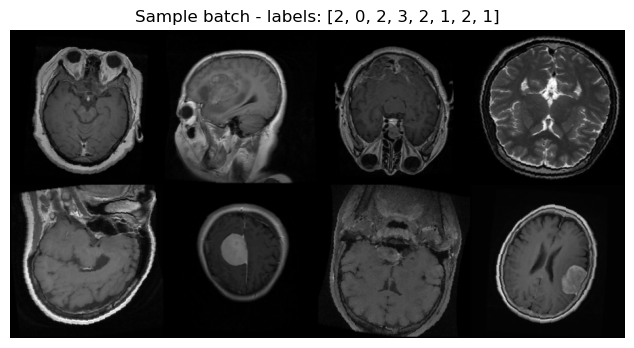

In [3]:
# 2. Visualize a batch of training images
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

loader = DataLoader(
    BrainTumor(DATA_DIR, 'train', get_grey_transforms()),
    batch_size=8, shuffle=True
)
imgs, labs = next(iter(loader))
grid = make_grid(imgs, nrow=4, normalize=True)
plt.figure(figsize=(8,4))
plt.imshow(grid.permute(1, 2, 0).squeeze(), cmap='gray')
plt.title('Sample batch - labels: ' + str(labs.tolist()))
plt.axis('off')
plt.show()

In [4]:
# 3. Overfit a tiny subset to check training loop (with transforms!)
from torch.utils.data import Subset

# Create a dataset *with* your greyscale transforms
train_ds_transformed = BrainTumor(
    root_dir=DATA_DIR,
    split='train',
    transform=get_grey_transforms()   # <-- apply here
)

# Take the first 32 samples
subset_indices = list(range(32))
train_small = Subset(train_ds_transformed, subset_indices)

loader_small = DataLoader(
    train_small,
    batch_size=8,
    shuffle=True,
    num_workers=0    # use 0 workers to avoid issues in notebooks
)

model     = CNN(num_classes=4).to(DEVICE)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

for epoch in range(1, 21):
    model.train()
    total_loss = 0.0
    correct    = 0

    for imgs, lbls in loader_small:        # now imgs are tensors
        imgs, lbls = imgs.to(DEVICE), lbls.to(DEVICE)
        optimizer.zero_grad()
        out   = model(imgs)
        loss  = criterion(out, lbls)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * imgs.size(0)
        preds      = out.argmax(dim=1)
        correct   += (preds == lbls).sum().item()

    avg_loss = total_loss / len(train_small)
    avg_acc  = correct    / len(train_small)
    print(f'Epoch {epoch:02d} – Loss: {avg_loss:.4f}, Acc: {avg_acc:.4f}')

    if correct == len(train_small):
        print('→ Perfect overfit achieved!')
        break


Epoch 01 – Loss: 0.6113, Acc: 0.7500
Epoch 02 – Loss: 0.0037, Acc: 1.0000
→ Perfect overfit achieved!


In [21]:
# 4. Full training run (reuse train.py logic)
import argparse
from train import main as train_main

args = {
    'data_dir': DATA_DIR,
    'output_dir': 'checkpoints',
    'batch_size': 32,
    'learning_rate': 0.005,
    'reg': 1e-3,
    'epochs': 20,
    'steps': 10,
    'warmup': 0,
    'momentum': 0.9
}

# Build a Namespace and call your train entrypoint
train_main(argparse.Namespace(**args))

train_losses, train_accs, val_losses, val_accs = train_main(args)


Epoch 01/20  Train loss=1.0169, acc=0.5671   Val loss=0.8795, acc=0.6911
→ Saved best model to checkpoints/best_model.pth


Epoch 02/20  Train loss=0.7591, acc=0.6947   Val loss=0.6827, acc=0.7056
→ Saved best model to checkpoints/best_model.pth


Epoch 03/20  Train loss=0.6586, acc=0.7316   Val loss=0.5632, acc=0.7750
→ Saved best model to checkpoints/best_model.pth


Epoch 04/20  Train loss=0.5877, acc=0.7614   Val loss=0.5661, acc=0.7689


Epoch 05/20  Train loss=0.5471, acc=0.7777   Val loss=0.5010, acc=0.8063
→ Saved best model to checkpoints/best_model.pth


Epoch 06/20  Train loss=0.5074, acc=0.7960   Val loss=0.4521, acc=0.8101
→ Saved best model to checkpoints/best_model.pth


Epoch 07/20  Train loss=0.4885, acc=0.8083   Val loss=0.4103, acc=0.8200
→ Saved best model to checkpoints/best_model.pth


Epoch 08/20  Train loss=0.4523, acc=0.8237   Val loss=0.4805, acc=0.7849


Epoch 09/20  Train loss=0.4263, acc=0.8321   Val loss=0.3706, acc=0.8452
→ Saved best model to checkpoints/best_model.pth


Epoch 10/20  Train loss=0.4048, acc=0.8424   Val loss=0.3641, acc=0.8406


Epoch 11/20  Train loss=0.3537, acc=0.8601   Val loss=0.3186, acc=0.8719
→ Saved best model to checkpoints/best_model.pth


KeyboardInterrupt: 

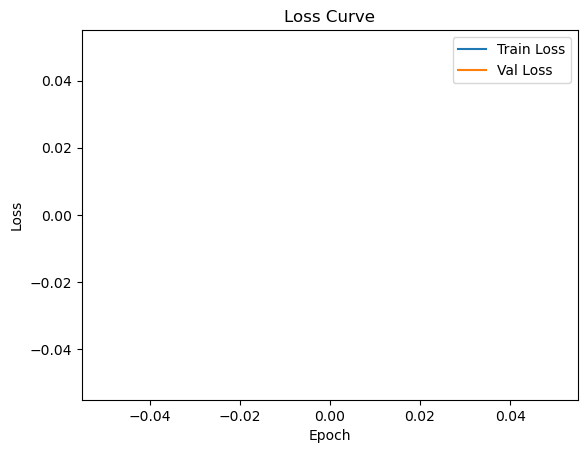

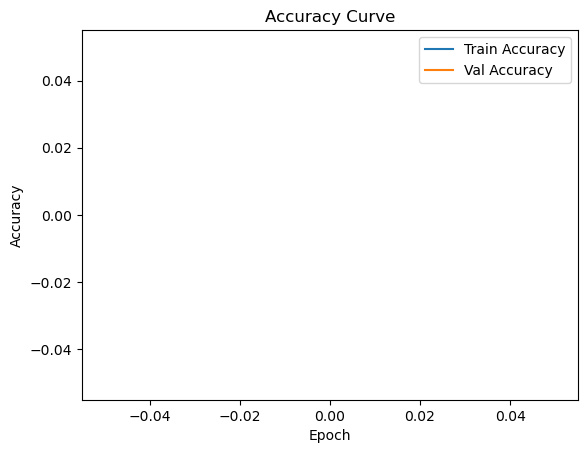

In [ ]:
import matplotlib.pyplot as plt

# Assuming train_losses, val_losses, train_accs, val_accs are defined
epochs = range(1, len(train_losses) + 1)

# Plot Loss Curve
plt.figure()
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curve')
plt.show()

# Plot Accuracy Curve
plt.figure()
plt.plot(epochs, train_accs, label='Train Accuracy')
plt.plot(epochs, val_accs, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Curve')
plt.show()


In [18]:
# Configuration
DATA_DIR        = 'data/kaggle'
BATCH_SIZE      = 32
DEVICE          = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
CHECKPOINT_PATH = 'checkpoints/best_model.pth'

# Load test set
test_ds     = BrainTumor(DATA_DIR, split='test', transform=get_val_transforms())
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

# Load model
model = CNN(num_classes=4).to(DEVICE)
model.load_state_dict(torch.load(CHECKPOINT_PATH, map_location=DEVICE))
model.eval()

# Inference
y_true, y_pred = [], []
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(DEVICE)
        outputs = model(imgs)
        preds = outputs.argmax(dim=1).cpu().tolist()
        y_pred.extend(preds)
        y_true.extend(labels.tolist())

# Metrics
acc       = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall    = recall_score(y_true, y_pred, average='weighted')
f1        = f1_score(y_true, y_pred, average='weighted')

print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")

/var/folders/wc/4r05xmdx4j54fzcxr2k4jgl00000gn/T/ipykernel_92017/684147579.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(CHECKPOINT_P

Accuracy:  0.8909
Precision: 0.8945
Recall:    0.8909
F1 Score:  0.8896


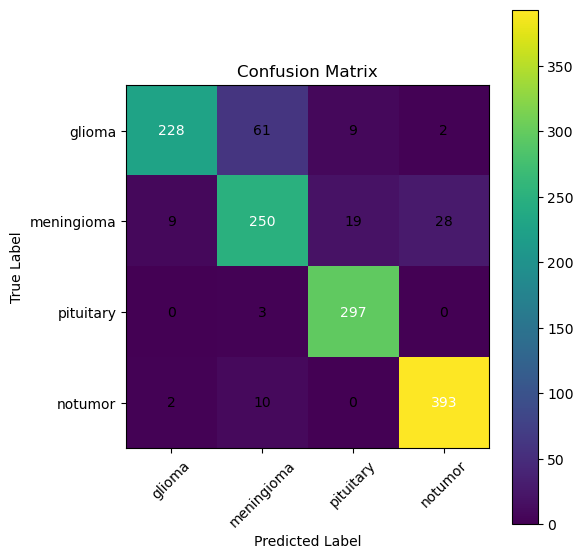

In [19]:
# You should already have y_true, y_pred from Cell 1
cm = confusion_matrix(y_true, y_pred)
labels = BrainTumor.CLASS_NAMES  # ['glioma','meningioma','pituitary','no_tumor']

plt.figure(figsize=(6,6))
plt.imshow(cm, interpolation='nearest')
plt.title('Confusion Matrix')
plt.colorbar()
plt.xticks(range(len(labels)), labels, rotation=45)
plt.yticks(range(len(labels)), labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Annotate each cell
thresh = cm.max() / 2
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j],
                 ha='center',
                 va='center',
                 color='white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.show()